# Проект "Отток клиентов"

Выполнил студент ds_plus_15 Черников Дмитрий Николаевич

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Признаки :**

**RowNumber** — индекс строки в данных

**CustomerId** — уникальный идентификатор клиента

**Surname** — фамилия

**CreditScore** — кредитный рейтинг

**Geography** — страна проживания

**Gender** — пол

**Age** — возраст

**Tenure** — сколько лет человек является клиентом банка

**Balance** — баланс на счёте

**NumOfProducts** — количество продуктов банка, используемых клиентом

**HasCrCard** — наличие кредитной карты

**IsActiveMember** — активность клиента

**EstimatedSalary** — предполагаемая зарплата


**Целевой признак :**

**Exited** — факт ухода клиента

In [1]:
#!pip install pandas-profiling[notebook]

In [2]:
import pandas as pd
import numpy as np

#import pandas_profiling

from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


#from pandas_profiling import ProfileReport

## Подготовка данных

In [3]:
df = pd.read_csv("Churn.csv")


In [4]:
# Первые три признака нам не нужны для моделирования, удалим их

df = df.drop(["RowNumber","CustomerId","Surname"], axis = 1)

In [5]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


В целом данные достаточно "чистые", в признаке **Tenure** есть пропуски. Так как наличие недвижимости является дополнительным фактором надежности клиента, то логично предположить, что если недвижимость не указана, то ее нет. Следовательно пропуски можно заменить на **"0"**, и перевести признак в тип **int**(заполнять пропуски медианой или средним значением выглядит плохой идеей, если банк не заполнил эти значения, то имел на то основания)

In [8]:
df.Tenure = df['Tenure'].fillna(0).astype('int64')

In [9]:
print("Количество дубликатов:",df.duplicated().sum())

Количество дубликатов: 0


Проверим категориальные признаки 

In [10]:
df.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [11]:
df.Gender.unique()

array(['Female', 'Male'], dtype=object)

In [12]:
df = pd.get_dummies(df,drop_first=True)

In [13]:
#df.head()

In [14]:
#df = df.drop(['Gender_Female'], axis = 1)

Ну и наведем немного красоты

In [15]:
df.columns = [x.lower() for x in df.columns]

In [16]:
df.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'geography_germany',
       'geography_spain', 'gender_male'],
      dtype='object')

In [17]:
df = df.rename(columns = {'creditscore':'credit_score', 'numofproducts':'num_of_products', 'hascrcard':'has_cr_card',
       'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'})

In [18]:
df.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  int64  
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_germany  10000 non-null  uint8  
 10  geography_spain    10000 non-null  uint8  
 11  gender_male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


На этом, пожалуй, закончим предобработку данных

In [20]:
#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile

## Исследование задачи

In [21]:
print('Количество ушедших клиентов:',(df.exited == 1).sum())

Количество ушедших клиентов: 2037


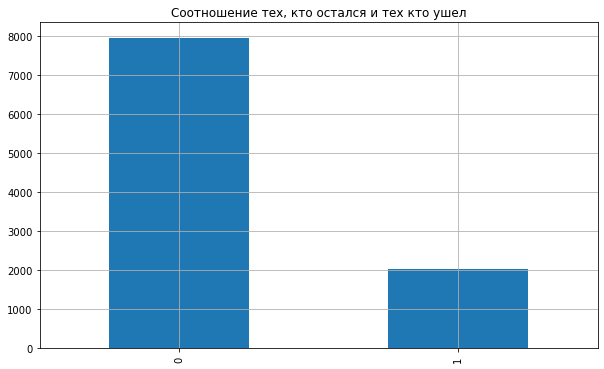

In [22]:
df.exited.value_counts().plot(kind='bar',grid=True,figsize=(10,6),title='Соотношение тех, кто остался и тех кто ушел')
plt.show()

In [23]:
#df.corr()

Первичный вывод, который мы можем сделать:

   - налицо дисбаланс классов в целевом признаке;
   
По условию задания необходимо обучить модель без учета дисбаланса класса этим и займемся

Попытка стандартизировать **train** выборку(т.к есть значения и маленькие и очень большие) методом **StandardScaler()** привела к резкому падению значений 
**f1_score** и **roc_auc_score**  и приближеню рок кривых к **Случайной модели**, пришлось от этого отказаться


Еще одно замечание перед исследованием - можно было бы перебрать значения гиперпараметров в цикле и вывести значение лучшей модели и ее параметров(мы так и делали в предыдущем проекте), но как утверждают преподаватели  - это совсем не **Pandas`way**, поэтому мы прибегнем к методу кросс валидации используя **GridSearchCV**

In [24]:
X = df.drop('exited', axis = 1)
y = df.exited

In [25]:
#X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [26]:
X.shape, y.shape

((10000, 11), (10000,))

In [27]:
# разделили на train и test
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)

In [28]:
X_train.shape, y_train.shape

((7500, 11), (7500,))

In [29]:
# выделили valid
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size = 0.25, random_state = 42)

In [30]:
X_train.shape, X_val.shape,X_test.shape

((5625, 11), (1875, 11), (2500, 11))

**DecisionTreeClassifier**

In [31]:
clf_dtc = DecisionTreeClassifier(random_state = 42)

In [32]:
param_dtc = {'criterion' : ['gini', 'entropy'], 'max_depth':range(1,30),}

In [33]:
gs_cv_dtc = GridSearchCV(clf_dtc, param_dtc, cv=5, scoring='f1')

In [34]:
%%time
gs_cv_dtc.fit(X_train,y_train)

Wall time: 19.4 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)},
             scoring='f1')

посмотрим параметры

In [35]:
gs_cv_dtc.best_params_

{'criterion': 'entropy', 'max_depth': 7}

сохраним лучшую модель

In [36]:
best_clf_dtc = gs_cv_dtc.best_estimator_

In [37]:
best_clf_dtc.score(X_val,y_val)

0.8528

In [38]:
y_pred_dtc = best_clf_dtc.predict(X_val)

In [39]:
f1_dtc = f1_score(y_val,y_pred_dtc)
f1_dtc

0.5605095541401274

In [40]:
y_predicted_prob_dtc = best_clf_dtc.predict_proba(X_val)

In [41]:
auc_roc_dtc = roc_auc_score(y_val, y_predicted_prob_dtc[:,1])
auc_roc_dtc

0.8166928807802991

**LogisticRegression**

In [42]:
clf_lr = LogisticRegression(random_state = 42)
param_lr = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]},
              {'solver': ['liblinear']}]
gs_cv_lr = GridSearchCV(clf_lr, 
                           param_grid = param_lr,
                           scoring = 'f1',
                           cv = 5,)

In [43]:
%%time

gs_cv_lr.fit(X_train,y_train)

Wall time: 7.32 s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]},
                         {'solver': ['liblinear']}],
             scoring='f1')

In [44]:
gs_cv_lr.best_params_

{'solver': 'liblinear'}

In [45]:
best_clf_lr = gs_cv_lr.best_estimator_
best_clf_lr.score(X_val,y_val)

0.7936

In [46]:
y_pred_lr = best_clf_lr.predict(X_val)
f1_lr = f1_score(y_val,y_pred_lr)
f1_lr

0.0851063829787234

In [47]:
y_predicted_prob_lr =  best_clf_lr.predict_proba(X_val)

In [48]:
auc_roc_lr = roc_auc_score(y_val, y_predicted_prob_lr[:,1])
auc_roc_lr

0.6528584403066355

**RandomForestClassifier**

In [49]:
clf_rfc = RandomForestClassifier(random_state = 42)
param_rfc = {'n_estimators': range (5, 31, 1), 'max_depth':range(1,15),}
gs_cv_clf = GridSearchCV(clf_rfc, param_rfc, cv=5, scoring='f1')

In [50]:
%%time
gs_cv_clf.fit(X_train,y_train)

Wall time: 5min 5s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': range(1, 15),
                         'n_estimators': range(5, 31)},
             scoring='f1')

In [51]:
gs_cv_clf.best_params_

{'max_depth': 14, 'n_estimators': 29}

In [52]:
best_clf_rfc = gs_cv_clf.best_estimator_
best_clf_rfc.score(X_val,y_val)

0.856

In [53]:
y_pred_rfc = best_clf_rfc.predict(X_val)
f1_rfc = f1_score(y_val,y_pred_rfc)
f1_rfc

0.564516129032258

In [54]:
y_predicted_prob_rfc =  best_clf_rfc.predict_proba(X_val)
auc_roc_rfc = roc_auc_score(y_val, y_predicted_prob_rfc[:,1])
auc_roc_rfc

0.843106790035389

In [55]:
result = {'DecisionTreeClassifier':[f1_dtc,auc_roc_dtc],
          'LogisticRegression':[f1_lr,auc_roc_lr],
          'RandomForestClassifier':[f1_rfc,auc_roc_rfc]}

result_df = pd.DataFrame(result, index=['f1_score','AUC ROC'])


Соберем результаты исследования в единую таблицу и построим график **ROC-кривых**

In [56]:
result_df

,DecisionTreeClassifier,LogisticRegression,RandomForestClassifier
f1_score,0.560510,0.085106,0.564516
AUC ROC,0.816693,0.652858,0.843107


In [57]:
fpr_tree,tpr_tree,thresholds = roc_curve(y_val, y_predicted_prob_dtc[:,1])
fpr_log, tpr_log, thresholds = roc_curve(y_val, y_predicted_prob_lr[:,1])
fpr_forest,tpr_forest, thresholds = roc_curve(y_val, y_predicted_prob_rfc[:,1])

<Figure size 432x288 with 0 Axes>

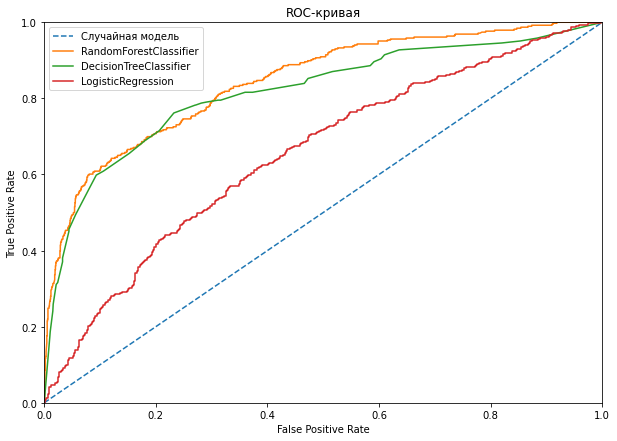

In [58]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_forest,tpr_forest)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_log,tpr_log)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','RandomForestClassifier','DecisionTreeClassifier','LogisticRegression'),
           loc= 'upper left') 
plt.show()


Это тот самый случай, когда "наглядная агитация" лучше пространных отчетов. Лучшая модель **RandomForestClassifier**, немного ей уступает **DecisionTreeClassifier**, а **LogisticRegression** осталась далеко позади

В результате проведенного исследования найдена лучшая модель **RandomForestClassifier** с гиперпараметрами
**'max_depth'**: 9, **'n_estimators'**: 20

показатели модели на тестовой выборке: **f1_score** = 0.6062322946175637 и **AUC ROC** = 0.8503542473010806


Наиболее важными признаками, влияющими на отток клиентов являются:

**age** = 0.321184

**num_of_products** = 0.207040

**balance** = 0.110723

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- []  Выполнен шаг 3: учтён дисбаланс
    - []  Применено несколько способов борьбы с дисбалансом
    - []  Написаны выводы по результатам исследования
- []  Выполнен шаг 4: проведено тестирование
- []  Удалось достичь *F1*-меры не менее 0.59
- []  Исследована метрика *AUC-ROC*